In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import common_corpus, common_dictionary, common_texts
from gensim.models import LdaModel

In [2]:
np.random.seed(1)

In [3]:
common_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

In [4]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [5]:
dict(common_dictionary)

{0: 'computer',
 1: 'human',
 2: 'interface',
 3: 'response',
 4: 'survey',
 5: 'system',
 6: 'time',
 7: 'user',
 8: 'eps',
 9: 'trees',
 10: 'graph',
 11: 'minors'}

In [6]:
from gensim.models.callbacks import Callback, Metric

In [7]:
class Foo(Callback):
    def __init__(self):
        pass
    def __str__(self):
        return "FOO"
    def __repr__(self):
        return self.__str__()
    def get_value(*args, **kwargs):
        return 0
    def __getattribute__(self, name):
        if name == "logger":
            return None
        def func(*args, **kwargs):
            print("{} called with args = {}, kwargs = {}".format(name, args, kwargs))
        return func

In [8]:
lda = LdaModel(corpus=common_corpus, num_topics=3, id2word=common_dictionary)#, callbacks=[Foo()])

In [9]:
lda.get_topics()

array([[0.09991315, 0.03180536, 0.03219635, 0.08912607, 0.17471717,
        0.09523831, 0.09889168, 0.08675566, 0.03297976, 0.03802519,
        0.11181334, 0.10853791],
       [0.11099348, 0.19903353, 0.11578164, 0.03308505, 0.03267179,
        0.20439455, 0.03299609, 0.03511733, 0.11463977, 0.04719991,
        0.03913659, 0.03495036],
       [0.03130063, 0.02087262, 0.07347195, 0.08797028, 0.03108724,
        0.0874393 , 0.08150668, 0.1444235 , 0.07367393, 0.16928692,
        0.12514158, 0.07382545]], dtype=float32)

In [10]:
topic_names = [lda.id2word[i] for i in range(len(lda.id2word))]

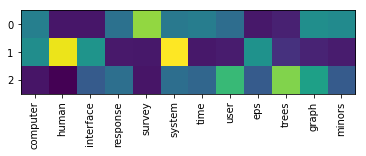

In [11]:
fig, ax = plt.subplots()
ax.imshow(lda.get_topics())
ax.set_xticks(np.arange(len(lda.id2word)))
ax.set_xticklabels(topic_names, rotation = 'vertical')
None

In [12]:
lda.get_topics().sum(axis=1)

array([1.       , 1.       , 1.0000001], dtype=float32)

In [13]:
lda.print_topics()

[(0,
  '0.175*"survey" + 0.112*"graph" + 0.109*"minors" + 0.100*"computer" + 0.099*"time" + 0.095*"system" + 0.089*"response" + 0.087*"user" + 0.038*"trees" + 0.033*"eps"'),
 (1,
  '0.204*"system" + 0.199*"human" + 0.116*"interface" + 0.115*"eps" + 0.111*"computer" + 0.047*"trees" + 0.039*"graph" + 0.035*"user" + 0.035*"minors" + 0.033*"response"'),
 (2,
  '0.169*"trees" + 0.144*"user" + 0.125*"graph" + 0.088*"response" + 0.087*"system" + 0.082*"time" + 0.074*"minors" + 0.074*"eps" + 0.073*"interface" + 0.031*"computer"')]

In [43]:
lda.state.sstats

(3, 12)

## Trying out collapsed gibbs

In [14]:
vocab_size = max(max(1 + v[0] for v in doc) for doc in common_corpus)
vocab_size

12

In [15]:
doc_lengths = [sum(x[1] for x in doc) for doc in common_corpus]
corpus_length = sum(doc_lengths)

In [16]:
doc_lengths

[3, 6, 4, 4, 3, 1, 2, 3, 3]

In [17]:
corpus_length

29

In [18]:
K = 3

In [19]:
# Initialization
Z = [np.random.choice(K, size=L) for L in doc_lengths]
Z

[array([0, 2, 2]),
 array([0, 1, 1, 2, 1, 2]),
 array([0, 1, 1, 0]),
 array([1, 1, 2, 2]),
 array([0, 2, 0]),
 array([2]),
 array([0, 2]),
 array([2, 0, 2]),
 array([0, 2, 0])]

In [20]:
burn_in = 10
lag = 20
num_samples = 100

In [21]:
import copy

In [22]:
import itertools

In [23]:
def flatten_one_level(L):
    return list(itertools.chain.from_iterable(L))

In [24]:
flatten_one_level([[1,2,3],[4,5,6],[7,8],[],[9]])

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
from tqdm import tqdm, tnrange

In [26]:
class CollapsedGibbs(object):
    def fit(self, corpus, num_topics, vocab_size, burn_in = 10, lag = 20, num_samples = 100, alpha = 1.0, beta = 1.0):
        alpha = np.broadcast_to(alpha, (num_topics,))
        beta = np.broadcast_to(beta, (vocab_size,))
        beta_sum = beta.sum()
        lag = max(1, lag)
        burn_in = max(0, burn_in)
        num_samples = max(0, num_samples)

        doc_lengths = [sum(x[1] for x in doc) for doc in corpus]
        corpus_expanded = [flatten_one_level([w[0]] * w[1] for w in doc) for doc in corpus]
        Z = [np.random.choice(K, size=L) for L in doc_lengths]

        self.samples = []
        for i in tnrange(burn_in + lag * num_samples):
            for doc_index in range(len(Z)):
                for pos_index in range(doc_lengths[doc_index]):
                    v = corpus_expanded[doc_index][pos_index]
                    probs = np.zeros(num_topics)
                    for k in range(num_topics):
                        A = 0.0  # num word-slots in current document [excluding pos_index] such that Z == k
                        B = 0.0  # num appearances of v in corpus [excluding doc_index, pos_index] such that Z == k
                        C = 0.0  # num word-slots in corpus [excluding doc_index, pos_index] such that Z == k
                        for di in range(len(corpus_expanded)):
                            for pi in range(doc_lengths[di]):
                                if di == doc_index and pi == pos_index:
                                    continue
                                if Z[di][pi] == k:
                                    C += 1
                                    if corpus_expanded[di][pi] == v:
                                        B += 1
                                    if doc_index == di:
                                        A += 1
                        # Combine these computations to yield probs[k] (unnormalized)
                        probs[k] = (alpha[k] + A) * (beta[v] + B) / (beta_sum + C)
                    probs /= probs.sum()
                    Znew = np.random.choice(num_topics, p = probs)
                    Z[doc_index][pos_index] = Znew

            if (i - burn_in) % lag == 0:
                self.samples.append(copy.deepcopy(Z))

        self.corpus = copy.deepcopy(corpus)
        self.corpus_expanded = corpus_expanded
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.alpha = alpha.copy()
        self.beta = beta.copy()

    def topics_by_sample(self):
        counts = np.zeros((len(self.samples), self.num_topics, self.vocab_size))
        for si, sample in enumerate(self.samples):
            for di, doc in enumerate(sample):
                for pi, z in enumerate(doc):
                    w = self.corpus_expanded[di][pi]
                    counts[si, z, w] += 1
        return counts / counts.sum(axis = 2, keepdims = True)

    def topics(self):
        counts = np.zeros((self.num_topics, self.vocab_size))
        for sample in self.samples:
            for di, doc in enumerate(sample):
                for pi, z in enumerate(doc):
                    w = self.corpus_expanded[di][pi]
                    counts[z, w] += 1
        return counts / counts.sum(axis = 1, keepdims = True)

In [27]:
result = CollapsedGibbs()
result.fit(common_corpus, num_topics = 5, vocab_size = vocab_size, num_samples = 1000)
len(result.samples)

1000

In [28]:
T = result.topics_by_sample()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [29]:
example_nan = np.array(np.where(np.isnan(T)))[0,0]

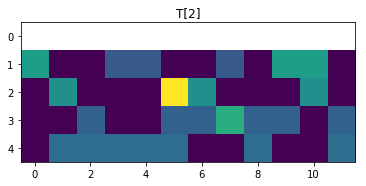

In [30]:
fig, ax = plt.subplots()
ax.imshow(T[example_nan])
ax.set_title("T[{}]".format(example_nan))
None

In [31]:
topics = result.topics()

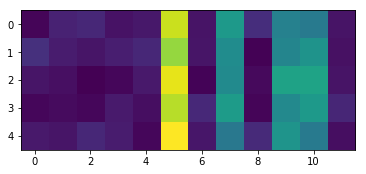

In [32]:
plt.imshow(topics);

In [33]:
from utils import niceprint

In [39]:
niceprint(topics)

[[0.0653 0.0718 0.0730 0.0680 0.0692 0.1378 0.0684 0.1071 0.0747 0.0992 0.0970 0.0684]
 [0.0754 0.0703 0.0689 0.0710 0.0730 0.1314 0.0687 0.1032 0.0646 0.1004 0.1052 0.0679]
 [0.0687 0.0675 0.0642 0.0656 0.0698 0.1410 0.0651 0.1025 0.0663 0.1103 0.1105 0.0684]
 [0.0658 0.0666 0.0658 0.0700 0.0671 0.1356 0.0736 0.1081 0.0654 0.1018 0.1074 0.0729]
 [0.0697 0.0686 0.0730 0.0702 0.0656 0.1441 0.0690 0.0962 0.0739 0.1056 0.0970 0.0672]]


In [35]:
[common_dictionary[i] for i in range(vocab_size)]

['computer',
 'human',
 'interface',
 'response',
 'survey',
 'system',
 'time',
 'user',
 'eps',
 'trees',
 'graph',
 'minors']

In [36]:
from collections import Counter

In [37]:
corpus_word_counts = Counter()
for doc in common_corpus:
    for w, c in doc:
        corpus_word_counts[w] += c
corpus_word_counts

Counter({0: 2,
         1: 2,
         2: 2,
         3: 2,
         4: 2,
         5: 4,
         6: 2,
         7: 3,
         8: 2,
         9: 3,
         10: 3,
         11: 2})

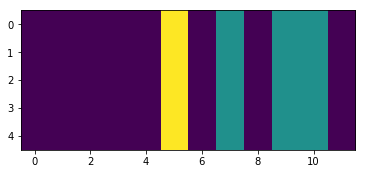

In [38]:
unif_topics = np.broadcast_to([corpus_word_counts[i] for i in range(vocab_size)], topics.shape).astype('float')
unif_topics /= unif_topics.sum(axis = 1, keepdims = True)
plt.imshow(unif_topics);